In [124]:
def DEMA(data, period):
    ema = data.ewm(span=period, adjust=False).mean()
    dema = 2 * ema - ema.ewm(span=period, adjust=False).mean()
    return dema

def TEMA(data, period):
    ema = data.ewm(span=period, adjust=False).mean()
    ema_ema = ema.ewm(span=period, adjust=False).mean()
    tema = 3 * ema - 3 * ema_ema + ema_ema.ewm(span=period, adjust=False).mean()
    return tema


#macd를 위함
short_period = 12  # 단기 이동 평균 기간
long_period = 26   # 장기 이동 평균 기간

In [125]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 파일이 있는 디렉토리 경로 설정
directory_path = r'/home/yjsong/study/C_stock/CSI300_NAME/test'
AllStock = pd.DataFrame() #피쳐 만들어진 종목들 취합용
engine_name = "china_stock"
# 디렉토리 내의 모든 CSV 파일을 읽어서 처리
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)

        # CSV 파일을 데이터프레임으로 읽기
        df = pd.read_csv(file_path, encoding='utf-8-sig')  # 필요한 인코딩을 사용하세요        
       
        # 여기에 원하는 피쳐 계산식 추가 
        # 날짜를 날짜 형식으로 변경
        df['TradingDate'] = pd.to_datetime(df['TradingDate'])
        
        ##--- 가격/거래량 이동 평균 관련 피쳐 ---##
        moving_average_period = [5,10,20,60,120] #이평선 구하고싶은 수치 변경 가능
        for period in moving_average_period:        
            #이동평균선 계산
            df['MA'+str(period)] = df.groupby('Symbol')['ClosePrice'].transform(lambda x: x.rolling(period).mean())
            #이동평균선의 기울기 계산
            df['Grad'+str(period)] = df.groupby('Symbol')['MA'+str(period)].transform(lambda x: np.gradient(x))
            #거래량 이동평균선 계산
            df['VMA'+str(period)] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(period).mean())
            #거래량 이동평균선의 기울기 계산
            df['VGrad'+str(period)] = df.groupby('Symbol')['VMA'+str(period)].transform(lambda x: np.gradient(x))
            
            ##--- 이격도 관련 피쳐 ---##
            #이동평균선과 현재 가격의 차이 계산           
            df['Dis'+str(period)] = (df['ClosePrice'] / df['MA'+str(period)]) * 100
            df['Div'+str(period)] = df['ClosePrice'] - df['MA'+str(period)] 
            df['VDis'+str(period)] = (df['Volume'] / df['VMA'+str(period)]) * 100
            df['VDiv'+str(period)] = df['Volume'] - df['VMA'+str(period)]
            
            #지붕 지표들
            #ExponetialExponential Moving Average
            df['EMA'+str(period)] = df.groupby('Symbol')['ClosePrice'].transform(lambda x: x.ewm(span=period, adjust=False).mean())
            df['DEMA' + str(period)] = df.groupby('Symbol')['ClosePrice'].transform(lambda x: DEMA(x, period))
            df['TEMA' + str(period)] = df.groupby('Symbol')['ClosePrice'].transform(lambda x: TEMA(x, period))
             
            #지붕 지표들
            # VWAP 계산
            df['VWAP' + str(period)] = (df['ClosePrice'] * df['Volume']).cumsum() / df['Volume'].cumsum() 
            #ROC
            df['ROC' + str(period)] = 
        
        # True Range(TR) 계산
        std_period = 5
        df['High-Low'] = df['HighPrice'] - df['LowPrice']
        df['High-PrevClose'] = abs(df['HighPrice'] - df['ClosePrice'].shift(1))
        df['Low-PrevClose'] = abs(df['LowPrice'] - df['ClosePrice'].shift(1))
        df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
        # ATR 계산
        df['ATR'] = df['TR'].rolling(window=std_period).mean() 
        
        std_period = 5
        # 양수 및 음수의 가격 변동을 나누어 계산합니다.
        df['Gain'] = df['ChangeRatio'][df['ChangeRatio'] > 0]
        df['Loss'] = -df['ChangeRatio'][df['ChangeRatio'] < 0]

        # 평균 상승과 평균 하락을 계산합니다.
        average_gain = df['Gain'][:std_period].mean()
        average_loss = df['Loss'][:std_period].mean()

        # 상대 강도를 계산합니다.
        relative_strength = average_gain / average_loss

        # RSI를 계산합니다.
        rsi = 100 - (100 / (1 + relative_strength))
        df['RSI']=rsi
           
        # 단기 이동 평균 계산
        df['ShortEMA'] = df['ClosePrice'].ewm(span=short_period, adjust=False).mean()
        # 장기 이동 평균 계산
        df['LongEMA'] = df['ClosePrice'].ewm(span=long_period, adjust=False).mean()
        # MACD 계산
        df['MACD'] = df['ShortEMA'] - df['LongEMA']
        # MACD 신호선(신호선은 MACD의 9일 이동 평균)
        signal_period = 9
        df['SignalLine'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
        # MACD 히스토그램 계산
        df['MACD_Histogram'] = df['MACD'] - df['SignalLine']     
       
        # Bollinger Band: 주가의 표준편차 계산 - 일단 20일을 많이 써서 20일로 설정
        df['StdDev'] = df['ClosePrice'].rolling(window=20).std()
        # 상한선 (Upper Band) 계산
        df['UpperBand'] = df['MA20'] + (2 * df['StdDev'])
        # 하한선 (Lower Band) 계산
        df['LowerBand'] = df['MA20'] - (2 * df['StdDev']) 
        
        # Directional Movement Index (DMI) 계산
        df['UpMove'] = df['HighPrice'] - df['HighPrice'].shift(1)
        df['DownMove'] = df['LowPrice'].shift(1) - df['LowPrice']
        df['PlusDM'] = (df['UpMove'] > df['DownMove']) & (df['UpMove'] > 0)
        df['MinusDM'] = (df['DownMove'] > df['UpMove']) & (df['DownMove'] > 0)
        # Positive Directional Index (+DI) 및 Negative Directional Index (-DI) 계산
        df['PlusDI'] = (df['PlusDM'].rolling(window=std_period).sum() / df['TR'].rolling(window=std_period).sum()) * 100
        df['MinusDI'] = (df['MinusDM'].rolling(window=std_period).sum() / df['TR'].rolling(window=std_period).sum()) * 100
        # Average Directional Index (ADX) 계산
        df['ADX'] = ((df['PlusDI'] - df['MinusDI']).abs() / (df['PlusDI'] + df['MinusDI']).abs()).rolling(window=std_period).mean()
        
        df['OBV'] = df['Volume'].iloc[0] 
        # OBV를 계산합니다.
        for i in range(1, len(df)):
            if df['ClosePrice'].iloc[i] > df['ClosePrice'].iloc[i - 1]:
                df.at[i, 'OBV'] = df['OBV'].iloc[i - 1] + df['Volume'].iloc[i]
            elif df['ClosePrice'].iloc[i] < df['ClosePrice'].iloc[i - 1]:
                df.at[i, 'OBV'] = df['OBV'].iloc[i - 1] - df['Volume'].iloc[i]
            else:
                df.at[i, 'OBV'] = df['OBV'].iloc[i - 1]
                
        # Money Flow Multiplier 계산
        df['MoneyFlowMultiplier'] = ((df['ClosePrice'] - df['LowPrice']) - (df['HighPrice'] - df['ClosePrice'])) / (df['HighPrice'] - df['LowPrice'])
        # Money Flow Volume 계산
        df['MoneyFlowVolume'] = df['MoneyFlowMultiplier'] * df['Volume']
        # 20일 CMF 계산
        df['CMF'] = df['MoneyFlowVolume'].rolling(window=std_period).sum() / df['Volume'].rolling(window=std_period).sum()   
                     
        ##--- 일별 음봉 양봉 정보 ---# (1이면 양봉, 0이면 음봉 의미)
        df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)  
        ##--- 가격 변화량  ---# ROC 느낌 그냥 일단 5일 기준으로 
        df['PriceChange'] = df.groupby('Symbol')['ClosePrice'].pct_change(periods=5)*100  # 이전 5일 동안의 상승률 계산
        
        #몇 가지 더 개발해서 추가
        sp=np.fft.fft(df['ClosePrice'].values)
        df['ClosePrice_theta']=np.arctan(sp.imag/sp.real)
        numValues = len(df)
        numValuesHalf = numValues/2
        df['ClosePrice_amplitude']=np.sqrt(sp.real**2 + sp.imag**2)/numValuesHalf
        df['ClosePrice_freq'] = np.fft.fftfreq(sp.size, d=1)
        
        sp=np.fft.fft(df['Volume'].values)
        df['Volume_theta']=np.arctan(sp.imag/sp.real)
        numValues = len(df)
        numValuesHalf = numValues/2
        df['Volume_amplitude']=np.sqrt(sp.real**2 + sp.imag**2)/numValuesHalf
        df['Volume_freq'] = np.fft.fftfreq(sp.size, d=1)
        
        
        # 상승률이 10% 이상인 행 선택 : 이전 5일 동안 종가 상승률이 마이너스가 아닌 날짜 1, 아니면 0 
        df['Target'] =(df['PriceChange'] >= 0).astype(int)
    
        df = df.fillna(0) #NaN 데이터 모두 0으로 초기화
        
        #종목별로 나눠졌던 데이터를 합쳐?
        AllStock = pd.concat([AllStock, df], axis=0)
        print('----'+os.path.splitext(filename)[0] +' 종목 입력피쳐 계산 완료 ----')
        
        

----601390 종목 입력피쳐 계산 완료 ----
----601688 종목 입력피쳐 계산 완료 ----
----601328 종목 입력피쳐 계산 완료 ----
----601633 종목 입력피쳐 계산 완료 ----
----001289 종목 입력피쳐 계산 완료 ----
----000333 종목 입력피쳐 계산 완료 ----
----002180 종목 입력피쳐 계산 완료 ----
----601788 종목 입력피쳐 계산 완료 ----
----000166 종목 입력피쳐 계산 완료 ----
----601628 종목 입력피쳐 계산 완료 ----
----000596 종목 입력피쳐 계산 완료 ----
----000157 종목 입력피쳐 계산 완료 ----
----000002 종목 입력피쳐 계산 완료 ----
----601615 종목 입력피쳐 계산 완료 ----
----601658 종목 입력피쳐 계산 완료 ----
----601766 종목 입력피쳐 계산 완료 ----
----000301 종목 입력피쳐 계산 완료 ----
----000568 종목 입력피쳐 계산 완료 ----
----000069 종목 입력피쳐 계산 완료 ----
----601336 종목 입력피쳐 계산 완료 ----
----601857 종목 입력피쳐 계산 완료 ----
----601601 종목 입력피쳐 계산 완료 ----
----601698 종목 입력피쳐 계산 완료 ----
----601800 종목 입력피쳐 계산 완료 ----
----000625 종목 입력피쳐 계산 완료 ----
----601668 종목 입력피쳐 계산 완료 ----
----000408 종목 입력피쳐 계산 완료 ----
----601360 종목 입력피쳐 계산 완료 ----
----601318 종목 입력피쳐 계산 완료 ----
----601600 종목 입력피쳐 계산 완료 ----
----601728 종목 입력피쳐 계산 완료 ----
----601288 종목 입력피쳐 계산 완료 ----
----601398 종목 입력피쳐 계산 완료 ----
----601799

In [126]:
AllStock

,TradingDate,Symbol,ShortName,OpenPrice,ClosePrice,HighPrice,LowPrice,Volume,ChangeRatio,MA5,...,CMF,CandleType,PriceChange,ClosePrice_theta,ClosePrice_amplitude,ClosePrice_freq,Volume_theta,Volume_amplitude,Volume_freq,Target
0,2016-05-02,601390,中国中铁,6.396,6.396,6.396,6.396,0,0.00000,0.0000,...,0.000000,0,0.000000,0.000000,12.286032,0.000000,0.000000,1.404212e+08,0.000000,0
1,2016-05-03,601390,中国中铁,6.422,6.525,6.533,6.405,28973761,0.02017,0.0000,...,0.000000,1,0.000000,-1.014321,1.171470,0.000548,0.791383,3.966437e+07,0.000548,0
2,2016-05-04,601390,中国中铁,6.533,6.533,6.585,6.456,28778001,0.00123,0.0000,...,0.000000,0,0.000000,0.521833,0.230597,0.001096,0.257757,1.162200e+07,0.001096,0
3,2016-05-05,601390,中国中铁,6.525,6.516,6.542,6.473,21721092,-0.00260,0.0000,...,0.000000,0,0.000000,0.602034,0.243810,0.001644,-1.213946,6.357040e+06,0.001644,0
4,2016-05-06,601390,中国中铁,6.542,6.302,6.550,6.294,42331546,-0.03284,6.4544,...,0.000000,0,0.000000,-0.254211,0.187376,0.002192,-1.523277,4.359199e+06,0.002192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,2023-04-24,425,徐工机械,6.830,6.700,6.860,6.670,69603451,-0.02332,6.8980,...,-0.142894,0,-3.597122,-1.309032,0.274582,-0.002740,-0.342311,4.780487e+06,-0.002740,0
1821,2023-04-25,425,徐工机械,6.740,6.640,6.800,6.530,57543366,-0.00896,6.8200,...,-0.325911,0,-5.547653,-0.621034,0.348487,-0.002192,-0.319763,1.051820e+07,-0.002192,0
1822,2023-04-26,425,徐工机械,6.580,6.560,6.660,6.540,39602307,-0.01205,6.7460,...,-0.418620,0,-5.339105,-1.136164,0.276220,-0.001644,0.109695,3.173312e+06,-0.001644,0
1823,2023-04-27,425,徐工机械,6.520,6.670,6.680,6.440,44064986,0.01677,6.6860,...,-0.338382,1,-4.304161,0.094667,0.240539,-0.001096,-1.146314,1.771370e+07,-0.001096,0


In [92]:
#전체 데이터 중 학습/테스트/검증 3분류를 해서 딥러닝 용으로
#날짜 과거-현재 순으로 정렬
AllStock = AllStock.sort_values(by='TradingDate', ascending=True)  # ascending=True로 설정하면 오름차순으로 정렬

total_rows = len(AllStock)
input_size =  AllStock.shape[1]-4
split1_end = int(0.7 * total_rows)
split2_end = int(0.9 * total_rows)

data_split1 = AllStock[:split1_end]  # 70%의 데이터 = 학습용
data_split2 = AllStock[split1_end:split2_end]  # 20%의 데이터 = 테스트용
data_split3 = AllStock[split2_end:]  # 10%의 데이터 = 검증용

# 데이터를 CSV 파일로 저장
train_filename = engine_name + '_train.csv'
test_filename = engine_name+ '_test.csv'
vali_filename = engine_name + '_vali.csv'

#data_split1.to_csv(os.path.join(directory_path, train_filename), index=False, encoding='utf-8-sig')
#data_split2.to_csv(os.path.join(directory_path, vali_filename), index=False, encoding='utf-8-sig')
#data_split3.to_csv(os.path.join(directory_path, test_filename), index=False, encoding='utf-8-sig')

# 데이터를 TXT 파일로 저장
train_filename_txt = engine_name + '_train.txt'
vali_filename_txt = engine_name+ '_test.txt'
test_filename_txt = engine_name + '_vali.txt'

#data_split1.to_csv(os.path.join(directory_path, train_filename_txt), sep=' ', index=False, header=False, encoding='utf-8-sig')
#data_split2.to_csv(os.path.join(directory_path, vali_filename_txt), sep=' ', index=False, header=False, encoding='utf-8-sig')
#data_split3.to_csv(os.path.join(directory_path, test_filename_txt), sep=' ', index=False, header=False, encoding='utf-8-sig')

In [93]:
AllStock

,TradingDate,Symbol,ShortName,OpenPrice,ClosePrice,HighPrice,LowPrice,Volume,ChangeRatio,MA5,...,MACD_Histogram,CandleType,PriceChange,ClosePrice_theta,ClosePrice_amplitude,ClosePrice_freq,Volume_theta,Volume_amplitude,Volume_freq,Target
0,2016-05-02,601390,中国中铁,6.396,6.396,6.396,6.396,0,0.00000,0.000,...,0.000000,0,0.000000,0.000000,12.286032,0.000000,0.000000,1.404212e+08,0.000000,0
0,2016-05-02,408,*ST 金源,12.820,12.820,12.820,12.820,0,0.00000,0.000,...,0.000000,0,0.000000,0.000000,30.716697,0.000000,0.000000,2.005262e+07,0.000000,0
0,2016-05-02,601318,中国平安,26.099,26.099,26.099,26.099,0,0.00000,0.000,...,0.000000,0,0.000000,0.000000,107.816026,0.000000,0.000000,1.212935e+08,0.000000,0
0,2016-05-02,601600,中国铝业,4.182,4.182,4.182,4.182,0,0.00000,0.000,...,0.000000,0,0.000000,0.000000,9.287682,0.000000,0.000000,2.571873e+08,0.000000,0
0,2016-05-02,601288,农业银行,2.134,2.134,2.134,2.134,0,0.00000,0.000,...,0.000000,0,0.000000,0.000000,5.560918,0.000000,0.000000,4.531049e+08,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,2023-04-28,601615,明阳智能,21.250,20.660,21.280,20.620,30100892,-0.02731,20.758,...,-0.039708,0,-1.619048,-1.565328,8.177876,-0.000898,1.373042,1.877111e+07,-0.000898,0
1367,2023-04-28,601838,成都银行,13.610,13.740,13.850,13.490,31399122,-0.00073,13.712,...,-0.012969,1,-1.008646,-1.149149,3.872567,-0.000731,0.781742,5.142932e+06,-0.000731,0
329,2023-04-28,1289,龙源电力,17.880,18.030,18.100,17.730,3058532,0.00390,17.708,...,0.051550,1,1.577465,1.199871,2.759686,-0.003030,1.326682,2.093998e+06,-0.003030,1
883,2023-04-28,601658,邮储银行,5.400,5.510,5.550,5.330,163141876,0.00182,5.482,...,0.046662,1,3.377111,0.651463,0.261494,-0.001131,0.907867,2.710114e+07,-0.001131,1


In [94]:
from tensorflow.keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : 
    # round : 
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # target set 0(Negative) or 1(Positive)
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # Prediction result set 0(Negative) or 1(Positive)

    # True Positive
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) 
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : 
    # round :
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) 
    y_target_yn = K.round(K.clip(y_target, 0, 1)) 

    # True Positive
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) 
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [95]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.models import load_model 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [96]:
#학습코드 여기다가 만들어보자
start_column_index = 3  # 입력피쳐 시작 열의 인덱스 
end_column_index = -1  # 타겟 전까지의 인덱스 (타겟은 맨 뒤에 있음)
date_column_index = 0

#_x는 input feature만 구성되어 있음
#_y는 target으로만 구성되어 있음
train_x = data_split1.iloc[:, start_column_index:end_column_index]  
train_y = data_split1.iloc[:, end_column_index] 
train_x = train_x.reset_index(drop=True) #index 초기화
train_y = train_y.reset_index(drop=True)

vali_code_arr = data_split2['Symbol'].apply(lambda x: str(x).zfill(6)).tolist()
vali_date_arr = data_split2['TradingDate'].tolist() #예측 결과 날짜랑 코드 뽑으려고 list에 일단 차곡
vali_x = data_split2.iloc[:, start_column_index:end_column_index] 
vali_y = data_split2.iloc[:, end_column_index] 

test_code_arr = data_split3['Symbol'].apply(lambda x: str(x).zfill(6)).tolist()
test_date_arr = data_split3['TradingDate'].tolist()
test_x = data_split3.iloc[:, start_column_index:end_column_index] 
test_y = data_split3.iloc[:, end_column_index] 

In [97]:
train_x

,OpenPrice,ClosePrice,HighPrice,LowPrice,Volume,ChangeRatio,MA5,Grad5,VMA5,VGrad5,...,SignalLine,MACD_Histogram,CandleType,PriceChange,ClosePrice_theta,ClosePrice_amplitude,ClosePrice_freq,Volume_theta,Volume_amplitude,Volume_freq
0,6.396,6.396,6.396,6.396,0,0.00000,0.0000,0.0000,0.0,0.0,...,0.000000,0.000000,0,0.000000,0.000000,12.286032,0.000000,0.000000,1.404212e+08,0.000000
1,12.820,12.820,12.820,12.820,0,0.00000,0.0000,0.0000,0.0,0.0,...,0.000000,0.000000,0,0.000000,0.000000,30.716697,0.000000,0.000000,2.005262e+07,0.000000
2,26.099,26.099,26.099,26.099,0,0.00000,0.0000,0.0000,0.0,0.0,...,0.000000,0.000000,0,0.000000,0.000000,107.816026,0.000000,0.000000,1.212935e+08,0.000000
3,4.182,4.182,4.182,4.182,0,0.00000,0.0000,0.0000,0.0,0.0,...,0.000000,0.000000,0,0.000000,0.000000,9.287682,0.000000,0.000000,2.571873e+08,0.000000
4,2.134,2.134,2.134,2.134,0,0.00000,0.0000,0.0000,0.0,0.0,...,0.000000,0.000000,0,0.000000,0.000000,5.560918,0.000000,0.000000,4.531049e+08,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58324,23.065,23.065,23.183,22.780,34393563,-0.00043,23.2398,0.0570,42277901.0,3933306.2,...,0.442969,-0.046995,0,-0.508994,1.272091,0.011797,-0.276712,0.336563,1.850048e+06,-0.276712
58325,7.594,7.740,7.822,7.584,115659568,0.02057,7.6686,0.0612,96814250.0,23152340.5,...,-0.082137,-0.024007,1,-1.401274,-0.336378,0.007389,-0.276712,0.107865,1.430710e+06,-0.276712
58326,4.228,4.228,4.254,4.219,83065392,0.00000,4.2558,-0.0087,75781851.2,6448794.8,...,0.020112,-0.006807,0,-1.422243,-0.458838,0.001027,-0.276712,0.655649,3.263021e+06,-0.276712
58327,23.581,23.322,23.581,23.251,72921236,-0.01433,23.8282,-0.1300,52700694.0,4307361.2,...,-0.525712,-0.036673,0,-3.428571,-1.270987,0.025599,-0.276712,0.299040,2.612163e+06,-0.276712


In [98]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)
scaler = scaler.fit(test_x)
test_x = scaler.transform(test_x)
scaler = scaler.fit(vali_x)
vali_x = scaler.transform(vali_x)

In [99]:
train_x

array([[-4.65875715e-01, -4.65758603e-01, -4.67578094e-01, ...,
         1.07076094e-02,  2.60752159e+01, -1.92097351e-01],
       [-2.33692154e-01, -2.34132374e-01, -2.40119808e-01, ...,
         1.07076094e-02,  3.45395715e+00, -1.92097351e-01],
       [ 2.46252665e-01,  2.44660385e-01,  2.30057429e-01, ...,
         1.07076094e-02,  2.24804938e+01, -1.92097351e-01],
       ...,
       [-5.44234053e-01, -5.43928849e-01, -5.43421127e-01, ...,
         7.37613659e-01,  2.98632513e-01, -1.06396558e+00],
       [ 1.55244226e-01,  1.44531799e-01,  1.40901146e-01, ...,
         3.42248157e-01,  1.76314680e-01, -1.06396558e+00],
       [-1.08022440e-01, -1.10134460e-01, -1.17007657e-01, ...,
         1.20837673e+00, -1.28602223e-01, -1.06396558e+00]])

In [100]:
num_timesteps = 4

# train_x 데이터가 (58329, 54) 형태인 경우
train_x_l = np.array(train_x)  # train_x를 NumPy 배열로 변환
test_x_l = np.array(test_x)  
vali_x_l = np.array(vali_x)  

num_timesteps = 5  # num_timesteps 값을 5로 설정

# train_x 데이터를 (58329, 5, 54) 형태로 변환
l_train_x = []
l_test_x = []
l_vali_x = []

# train_x 데이터를 시계열 데이터로 변환
for i in range(len(train_x_l) - num_timesteps + 1):
    l_train_x.append(train_x_l[i:i+num_timesteps])
    
for i in range(len(test_x_l) - num_timesteps + 1):
    l_test_x.append(test_x_l[i:i+num_timesteps])
    
for i in range(len(vali_x_l) - num_timesteps + 1):
    l_vali_x.append(vali_x_l[i:i+num_timesteps])

# 리스트를 NumPy 배열로 변환
l_train_x = np.array(l_train_x)
l_test_x = np.array(l_test_x)
l_vali_x = np.array(l_vali_x)

# TensorFlow 텐서로 변환
l_train_x = tf.convert_to_tensor(l_train_x, dtype=tf.float32)
l_test_x = tf.convert_to_tensor(l_test_x, dtype=tf.float32)
l_vali_x = tf.convert_to_tensor(l_vali_x, dtype=tf.float32)

l_train_y = train_y[num_timesteps - 1:]  # 시간 스텝에 따라 맞추기
l_test_y = test_y[num_timesteps - 1:]
l_vali_y = vali_y[num_timesteps - 1:]

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  

In [101]:
with tf.device('/GPU:0'):     
    train_x = np.array(train_x).reshape(-1, input_size) #2차원 배열로 바꾸기
    test_x = np.array(test_x).reshape(-1, input_size)
    vali_x =  np.array(vali_x).reshape(-1, input_size)    

    train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
    #train_y = tf.convert_to_tensor(train_y, dtype=tf.float32)

    vali_x = tf.convert_to_tensor(vali_x, dtype=tf.float32)
    #vali_y = tf.convert_to_tensor(vali_y, dtype=tf.float32)

    test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)

class 0: 28091 
class 1: 30238 


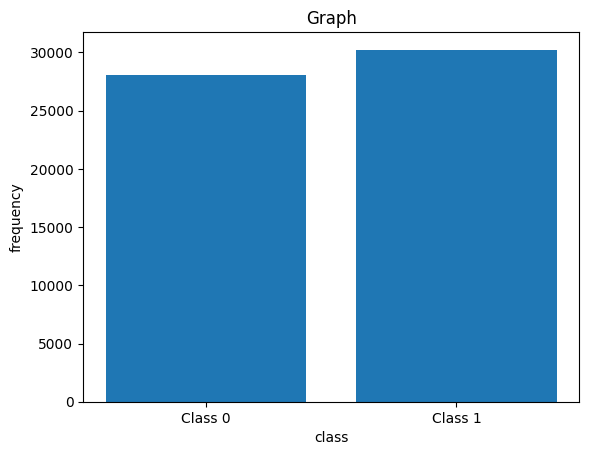

In [102]:
train_y
unique, counts = np.unique(train_y, return_counts=True)

# 막대 그래프 그리기
plt.bar(unique, counts)

# 그래프 제목과 축 레이블 추가
plt.title('Graph')
plt.xlabel('class')
plt.ylabel('frequency')

# x축 값 설정
plt.xticks(unique, ['Class 0', 'Class 1'])
for label, count in zip(unique, counts):
    print(f'class {label}: {count} ')
# 그래프 표시
plt.show()

In [103]:
print(len(train_x))
print(len(vali_x))
print(len(test_x))

58329
16666
8333


In [104]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [105]:
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # 가중치 행렬 W_q, W_k, W_v를 정의합니다.
        self.W_q = self.add_weight(name='W_q', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.W_k = self.add_weight(name='W_k', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.W_v = self.add_weight(name='W_v', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # 입력 데이터 x에서 쿼리(Q), 키(K), 밸류(V)를 계산합니다.
        Q = tf.matmul(x, self.W_q)
        K = tf.matmul(x, self.W_k)
        V = tf.matmul(x, self.W_v)

        # 어텐션 스코어를 계산합니다.
        attention_scores = tf.matmul(Q, K, transpose_b=True)
        
        # 소프트맥스 함수를 적용하여 어텐션 가중치를 계산합니다.
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        
        # 가중 평균을 통해 어텐션 값을 계산합니다.
        output = tf.matmul(attention_weights, V)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape


In [106]:
custom_optimizer = Adam(learning_rate=0.01)
custom_optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.01) #이거 ACC 잘나오는 듯?
custom_optimizer3 = tf.keras.optimizers.Ftrl(learning_rate=0.01)
custom_optimizer4 = tf.keras.optimizers.Adadelta(learning_rate=1.0)
custom_optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.001)
custom_optimizer6 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [107]:
#Attention input hidden output 모두 추가 버젼

batch_size = 150
epochs = 100

target_num = 1
custom_optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.001) #이거 ACC 잘나오는 듯?
with tf.device('/GPU:0'):

    model = Sequential()
    input_layer = tf.keras.layers.Input(shape=(input_size))
    attention_layer_input0 = AttentionLayer()(input_layer)
    mlp_layer1 = tf.keras.layers.Dense(200, activation='relu')(attention_layer_input0)

    # Attention Layer for the input (mlp_layer1)
    attention_layer_input = AttentionLayer()(mlp_layer1)

    mlp_layer2 = tf.keras.layers.Dense(50, activation='relu')(mlp_layer1)

    # Attention Layer for the intermediate layer (mlp_layer2)
    attention_layer_intermediate = AttentionLayer()(mlp_layer2)

    # Concatenate the two attention layers
    concatenated_attention = tf.keras.layers.Concatenate()([attention_layer_input, attention_layer_intermediate])

    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated_attention)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.summary()
    model.compile(optimizer=custom_optimizer2, loss='binary_crossentropy', metrics=['acc', precision, recall, f1score])
    
    # Fit and evaluate model 
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, 
                        validation_data = (vali_x, vali_y))

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 79)]                 0         []                            
                                                                                                  
 attention_layer_21 (Attent  (None, 79)                   18723     ['input_8[0][0]']             
 ionLayer)                                                                                        
                                                                                                  
 dense_15 (Dense)            (None, 200)                  16000     ['attention_layer_21[0][0]']  
                                                                                                  
 dense_16 (Dense)            (None, 50)                   10050     ['dense_15[0][0]']      

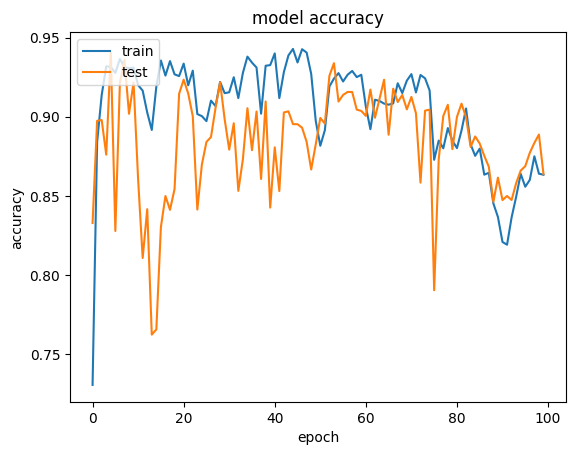

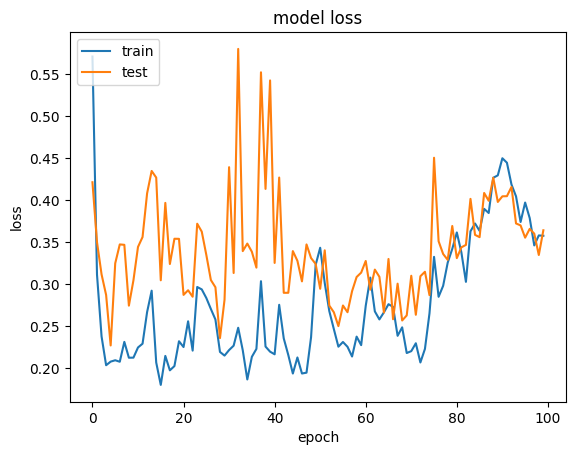

261/261 [==============================] - 1s 2ms/step - loss: 0.4930 - acc: 0.8208 - precision: 0.8399 - recall: 0.6776 - f1score: 0.7340
Test metrics: [0.4929927885532379, 0.8208328485488892, 0.839859127998352, 0.6775697469711304, 0.7340240478515625]


In [108]:
## summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate the model on the test data
test_metrics = model.evaluate(test_x, test_y, verbose=1)

# Print the test loss
print(f"Test metrics: {test_metrics}")

In [109]:
custom_optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.001) #이거 ACC 잘나오는 듯?

# Define the LSTM model
model = Sequential()

# Input layer with attention
input_layer = tf.keras.layers.Input(shape=(num_timesteps, input_size))
attention_layer_input = AttentionLayer()(input_layer)

# LSTM layers with attention at each time step
lstm1 = LSTM(50, return_sequences=True)(attention_layer_input)
attention_layer_lstm1 = AttentionLayer()(lstm1)

lstm2 = LSTM(50, return_sequences=True)(attention_layer_lstm1)
attention_layer_lstm2 = AttentionLayer()(lstm2)

lstm3 = LSTM(50)(attention_layer_lstm2)

# Output layer
output_layer = Dense(1, activation='sigmoid')(lstm3)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=custom_optimizer2, loss='binary_crossentropy', metrics=['acc', precision, recall, f1score])

# Fit and evaluate the LSTM model
history = model.fit(l_train_x, l_train_y, epochs=epochs, batch_size=batch_size, verbose=1, 
                    validation_data=(l_vali_x, l_vali_y))

Epoch 1/100


2023-11-12 15:16:45.274407: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA TITAN Xp" frequency: 1582 num_cores: 30 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 3145728 shared_memory_size_per_multiprocessor: 98304 memory_size: 11248926720 bandwidth: 547680000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-12 15:16:45.274720: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA TITAN Xp" frequency: 1

385/389 [============================>.] - ETA: 0s - loss: 0.5296 - acc: 0.7340 - precision: 0.7408 - recall: 0.7543 - f1score: 0.7451

2023-11-12 15:16:50.762140: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA TITAN Xp" frequency: 1582 num_cores: 30 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 3145728 shared_memory_size_per_multiprocessor: 98304 memory_size: 11248926720 bandwidth: 547680000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-12 15:16:50.762316: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA TITAN Xp" frequency: 1

389/389 [==============================] - 9s 13ms/step - loss: 0.5284 - acc: 0.7350 - precision: 0.7415 - recall: 0.7553 - f1score: 0.7459 - val_loss: 0.4247 - val_acc: 0.8126 - val_precision: 0.7887 - val_recall: 0.7379 - val_f1score: 0.7566
Epoch 2/100
389/389 [==============================] - 4s 10ms/step - loss: 0.2364 - acc: 0.9140 - precision: 0.9254 - recall: 0.9082 - f1score: 0.9159 - val_loss: 0.2001 - val_acc: 0.9344 - val_precision: 0.9015 - val_recall: 0.9490 - val_f1score: 0.9233
Epoch 3/100
389/389 [==============================] - 4s 10ms/step - loss: 0.1477 - acc: 0.9529 - precision: 0.9628 - recall: 0.9458 - f1score: 0.9539 - val_loss: 0.1757 - val_acc: 0.9449 - val_precision: 0.9122 - val_recall: 0.9623 - val_f1score: 0.9356
Epoch 4/100
389/389 [==============================] - 4s 10ms/step - loss: 0.1202 - acc: 0.9627 - precision: 0.9725 - recall: 0.9551 - f1score: 0.9634 - val_loss: 0.1556 - val_acc: 0.9541 - val_precision: 0.9350 - val_recall: 0.9559 - val_f1sc

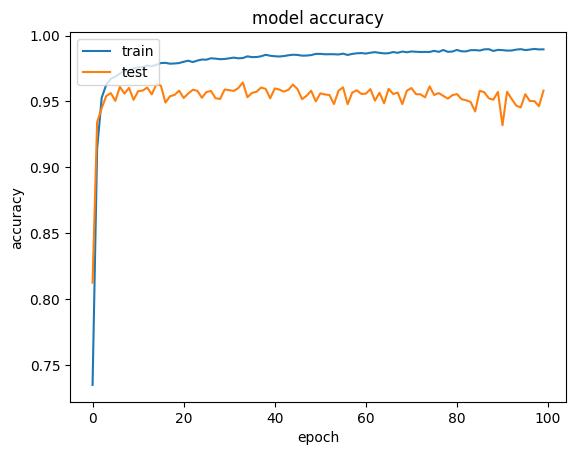

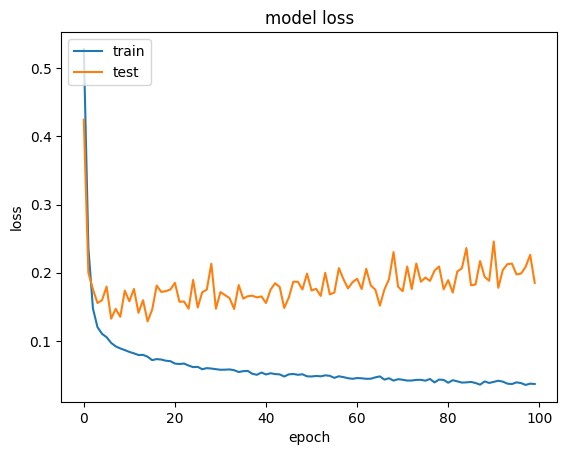

261/261 [==============================] - 1s 4ms/step - loss: 0.1832 - acc: 0.9557 - precision: 0.9648 - recall: 0.9282 - f1score: 0.9426
Test metrics: [0.18320666253566742, 0.9556969404220581, 0.9647964239120483, 0.928219199180603, 0.9426162838935852]


In [110]:
## summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate the model on the test data
test_metrics = model.evaluate(l_test_x, l_test_y, verbose=1)

# Print the test loss
print(f"Test metrics: {test_metrics}")